# Implementation and training of U-Net on custom dataset




This tutorial is an example of training of [U-Net](https://arxiv.org/abs/1505.04597) by Ronnenberger et al., 2015. This notebook shows the loading and training on **your own custom dataset**.

### **Steps Covered in this Tutorial**

To train U-Net we take the following steps:

* Implement the U-Net in PyTorch
* Load custom dataset visualise it
* Run U-Net training
* Run U-Net inference on test images


# Implementing the model from PyTorch



In [ ]:
import torch
import torch.nn as nn
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
from torchvision import models, transforms
from torch.nn.functional import relu, sigmoid
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# @title Implementation of U-Net, click to expand
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

# Loading a custom dataset

We will be using a custom dataset of retinal vessel images obtained from [Kaggle](https://www.kaggle.com/datasets/zionfuo/drive2004/data). Download the ```.zip``` and then on the side click on the folder icon and upload it on the space.


First, let's unzip the file.

In [ ]:
!unzip archive

Archive:  archive.zip
  inflating: DRIVE/test/1st_manual/01_manual1.gif  
  inflating: DRIVE/test/1st_manual/02_manual1.gif  
  inflating: DRIVE/test/1st_manual/03_manual1.gif  
  inflating: DRIVE/test/1st_manual/04_manual1.gif  
  inflating: DRIVE/test/1st_manual/05_manual1.gif  
  inflating: DRIVE/test/1st_manual/06_manual1.gif  
  inflating: DRIVE/test/1st_manual/07_manual1.gif  
  inflating: DRIVE/test/1st_manual/08_manual1.gif  
  inflating: DRIVE/test/1st_manual/09_manual1.gif  
  inflating: DRIVE/test/1st_manual/10_manual1.gif  
  inflating: DRIVE/test/1st_manual/11_manual1.gif  
  inflating: DRIVE/test/1st_manual/12_manual1.gif  
  inflating: DRIVE/test/1st_manual/13_manual1.gif  
  inflating: DRIVE/test/1st_manual/14_manual1.gif  
  inflating: DRIVE/test/1st_manual/15_manual1.gif  
  inflating: DRIVE/test/1st_manual/16_manual1.gif  
  inflating: DRIVE/test/1st_manual/17_manual1.gif  
  inflating: DRIVE/test/1st_manual/18_manual1.gif  
  inflating: DRIVE/test/1st_manual/19_manu

Now the ```./DRIVE``` folder should have been created with two folders, test and training data. So let's load it and visualize it.



In [ ]:
train_dir = './DRIVE/training'
test_dir = './DRIVE/test'


def load_data_from_directory(directory):
    image_list = []
    mask_list = []
    image_folder = os.path.join(directory, 'images')
    mask_folder = os.path.join(directory, '1st_manual')
    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

    for img_filename, mask_filename in zip(image_filenames, mask_filenames):
        if img_filename.endswith(".tif") and mask_filename.endswith(".gif"):
            img = Image.open(os.path.join(image_folder, img_filename))
            mask = Image.open(os.path.join(mask_folder, mask_filename))
            image_list.append(img)
            mask_list.append(mask)

    return image_list, mask_list
train_images, train_masks = load_data_from_directory(train_dir)
test_images, test_masks = load_data_from_directory(test_dir)

in the folders ```1st_manual``` is the hand segmented vessels masks where every pixel has a different value between (0, 255). The following code creates a function that will re-threshold the mask and normalize the mask to binary, i.e. [0,1].

Example plots will be shown below

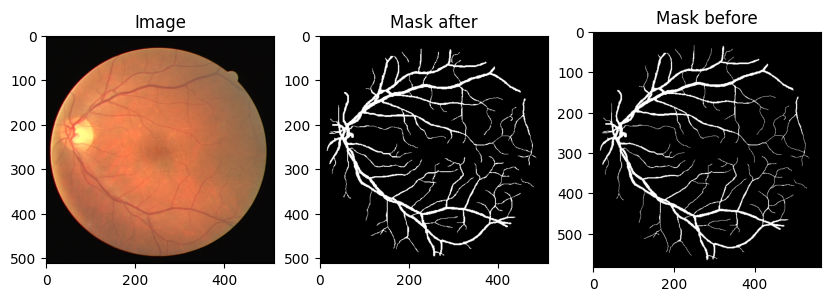

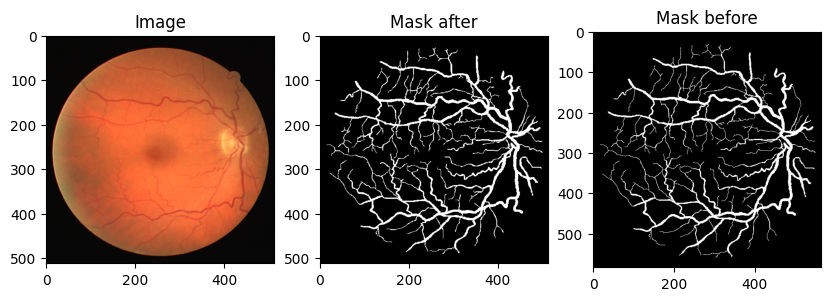

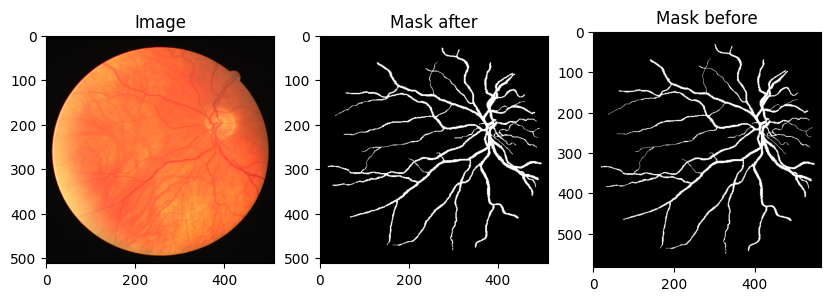

In [ ]:
def preprocess(images, masks):
    target_size = (512, 512)
    processed_images = []
    processed_masks = []

    for img, mask in zip(images, masks):

        mask_=np.array(mask)
        img_resized = img.resize(target_size, resample=Image.BILINEAR)
        mask_array = cv2.resize(mask_, target_size , interpolation=cv2.INTER_LINEAR)

        threshold_value = 70
        _,mask_array = cv2.threshold(mask_array, threshold_value, 255, cv2.THRESH_BINARY)
        img_array = np.array(img_resized)

        img_array = img_array.astype('float32') / 255.0

        mask_array = mask_array.astype('uint8') / 255

        processed_images.append(img_array)
        processed_masks.append(mask_array)

    return processed_images, processed_masks

train_images_processed, train_masks_processed = preprocess(train_images,train_masks)
test_images_processed, test_masks_processed = preprocess(test_images,test_masks)

for i in range(3):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    ax[0].imshow(train_images_processed[i], cmap='gray')
    ax[0].set_title('Image')

    ax[1].imshow(train_masks_processed[i], cmap='gray')
    ax[1].set_title('Mask after')

    mask_ = np.array(train_masks[i])
    ax[2].imshow(mask_/255, cmap='gray')
    ax[2].set_title('Mask before')

    plt.show()


# Load the data into dataloader for training

Dataloaders are classes and functions that do the processing and manipulation of datasets during training. They can shuffle the data randomly and then generate small batches of data to train the ML algorithm. with PyTorch it is very simple to adapt the dataloader for our custom data.

So first we need to define the dataset class.

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transforms):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
        return (image, mask)

As the model will take a specific input, we need to create processing pipeline using the ```transforms``` package.

In [ ]:
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((512, 512)),
                                  transforms.ToTensor()])

And with that we can load our processed images and masks into the dataset  and then into the PyTorch dataloader.

As we have both training and test set, we will create two dataloaders

In [ ]:
# create the train and test datasets
trainData = SegmentationDataset(train_images_processed, train_masks_processed,
                                transforms)
testData = SegmentationDataset(test_images_processed, test_masks_processed,
                              transforms)

# create the training and test data loaders
trainLoader = DataLoader(trainData, shuffle=True, batch_size=4,	num_workers=os.cpu_count())
testLoader = DataLoader(testData, shuffle=False, batch_size=4, num_workers=os.cpu_count())

# Start training

So let's define the U-Net model, the loss function and the optimization algorithm.


In [ ]:
unet = UNet(1).to(device)

lossFunc = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.001)

And now let's start the training!

*Elevator music*

In [ ]:
# loop over epochs
num_epochs = 100
trainSteps = len(trainData) // 4
testSteps = len(testData) // 4

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
    # set the model in training mode
    unet.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0

    # loop over the training set in batches
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))

        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)

        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        # add the loss to the total training loss so far
        totalTrainLoss += loss

    # switch off autograd to evaluate with the test set
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()

        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))

            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps

    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
          avgTrainLoss, avgTestLoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	    endTime - startTime))

[INFO] training the network...


  1%|          | 1/100 [00:06<11:22,  6.89s/it]

[INFO] EPOCH: 1/100
Train loss: 1.457237, Test loss: 0.4332


  2%|▏         | 2/100 [00:12<09:41,  5.93s/it]

[INFO] EPOCH: 2/100
Train loss: 0.503510, Test loss: 0.5290


  3%|▎         | 3/100 [00:17<09:07,  5.64s/it]

[INFO] EPOCH: 3/100
Train loss: 0.537722, Test loss: 0.4001


  4%|▍         | 4/100 [00:22<08:48,  5.51s/it]

[INFO] EPOCH: 4/100
Train loss: 0.429279, Test loss: 0.3949


  5%|▌         | 5/100 [00:28<08:38,  5.45s/it]

[INFO] EPOCH: 5/100
Train loss: 0.355906, Test loss: 0.3469


  6%|▌         | 6/100 [00:33<08:30,  5.43s/it]

[INFO] EPOCH: 6/100
Train loss: 0.338316, Test loss: 0.3283


  7%|▋         | 7/100 [00:38<08:25,  5.43s/it]

[INFO] EPOCH: 7/100
Train loss: 0.309530, Test loss: 0.2983


  8%|▊         | 8/100 [00:44<08:20,  5.44s/it]

[INFO] EPOCH: 8/100
Train loss: 0.293964, Test loss: 0.2936


  9%|▉         | 9/100 [00:49<08:17,  5.46s/it]

[INFO] EPOCH: 9/100
Train loss: 0.288203, Test loss: 0.2886


 10%|█         | 10/100 [00:55<08:13,  5.49s/it]

[INFO] EPOCH: 10/100
Train loss: 0.285292, Test loss: 0.2866


 11%|█         | 11/100 [01:01<08:10,  5.52s/it]

[INFO] EPOCH: 11/100
Train loss: 0.283665, Test loss: 0.2859


 12%|█▏        | 12/100 [01:06<08:08,  5.56s/it]

[INFO] EPOCH: 12/100
Train loss: 0.282934, Test loss: 0.2850


 13%|█▎        | 13/100 [01:12<08:06,  5.60s/it]

[INFO] EPOCH: 13/100
Train loss: 0.282098, Test loss: 0.2851


 14%|█▍        | 14/100 [01:18<08:05,  5.64s/it]

[INFO] EPOCH: 14/100
Train loss: 0.281634, Test loss: 0.2837


 15%|█▌        | 15/100 [01:24<08:06,  5.73s/it]

[INFO] EPOCH: 15/100
Train loss: 0.280857, Test loss: 0.2832


 16%|█▌        | 16/100 [01:29<08:05,  5.78s/it]

[INFO] EPOCH: 16/100
Train loss: 0.280624, Test loss: 0.2826


 17%|█▋        | 17/100 [01:35<08:06,  5.86s/it]

[INFO] EPOCH: 17/100
Train loss: 0.279658, Test loss: 0.2822


 18%|█▊        | 18/100 [01:42<08:06,  5.93s/it]

[INFO] EPOCH: 18/100
Train loss: 0.279069, Test loss: 0.2999


 19%|█▉        | 19/100 [01:48<08:06,  6.01s/it]

[INFO] EPOCH: 19/100
Train loss: 0.283350, Test loss: 0.2823


 20%|██        | 20/100 [01:54<08:03,  6.04s/it]

[INFO] EPOCH: 20/100
Train loss: 0.280061, Test loss: 0.2824


 21%|██        | 21/100 [02:00<07:56,  6.04s/it]

[INFO] EPOCH: 21/100
Train loss: 0.279189, Test loss: 0.2816


 22%|██▏       | 22/100 [02:06<07:48,  6.01s/it]

[INFO] EPOCH: 22/100
Train loss: 0.278827, Test loss: 0.2815


 23%|██▎       | 23/100 [02:12<07:39,  5.97s/it]

[INFO] EPOCH: 23/100
Train loss: 0.279001, Test loss: 0.2837


 24%|██▍       | 24/100 [02:18<07:31,  5.94s/it]

[INFO] EPOCH: 24/100
Train loss: 0.282410, Test loss: 0.2843


 25%|██▌       | 25/100 [02:23<07:22,  5.90s/it]

[INFO] EPOCH: 25/100
Train loss: 0.280468, Test loss: 0.2811


 26%|██▌       | 26/100 [02:29<07:14,  5.88s/it]

[INFO] EPOCH: 26/100
Train loss: 0.278086, Test loss: 0.2801


 27%|██▋       | 27/100 [02:35<07:06,  5.84s/it]

[INFO] EPOCH: 27/100
Train loss: 0.277823, Test loss: 0.2797


 28%|██▊       | 28/100 [02:41<06:59,  5.83s/it]

[INFO] EPOCH: 28/100
Train loss: 0.277469, Test loss: 0.2809


 29%|██▉       | 29/100 [02:47<06:54,  5.83s/it]

[INFO] EPOCH: 29/100
Train loss: 0.277871, Test loss: 0.2797


 30%|███       | 30/100 [02:53<06:49,  5.85s/it]

[INFO] EPOCH: 30/100
Train loss: 0.276843, Test loss: 0.2798


 31%|███       | 31/100 [02:58<06:44,  5.87s/it]

[INFO] EPOCH: 31/100
Train loss: 0.276458, Test loss: 0.2789


 32%|███▏      | 32/100 [03:04<06:41,  5.90s/it]

[INFO] EPOCH: 32/100
Train loss: 0.275910, Test loss: 0.2796


 33%|███▎      | 33/100 [03:10<06:35,  5.90s/it]

[INFO] EPOCH: 33/100
Train loss: 0.275882, Test loss: 0.2778


 34%|███▍      | 34/100 [03:16<06:30,  5.91s/it]

[INFO] EPOCH: 34/100
Train loss: 0.274451, Test loss: 0.2775


 35%|███▌      | 35/100 [03:22<06:24,  5.92s/it]

[INFO] EPOCH: 35/100
Train loss: 0.274391, Test loss: 0.2775


 36%|███▌      | 36/100 [03:28<06:18,  5.92s/it]

[INFO] EPOCH: 36/100
Train loss: 0.274284, Test loss: 0.2775


 37%|███▋      | 37/100 [03:34<06:12,  5.91s/it]

[INFO] EPOCH: 37/100
Train loss: 0.273135, Test loss: 0.2764


 38%|███▊      | 38/100 [03:40<06:05,  5.90s/it]

[INFO] EPOCH: 38/100
Train loss: 0.274377, Test loss: 0.2834


 39%|███▉      | 39/100 [03:46<05:58,  5.88s/it]

[INFO] EPOCH: 39/100
Train loss: 0.274136, Test loss: 0.2754


 40%|████      | 40/100 [03:52<05:51,  5.87s/it]

[INFO] EPOCH: 40/100
Train loss: 0.272955, Test loss: 0.2787


 41%|████      | 41/100 [03:57<05:46,  5.87s/it]

[INFO] EPOCH: 41/100
Train loss: 0.276983, Test loss: 0.2781


 42%|████▏     | 42/100 [04:03<05:39,  5.85s/it]

[INFO] EPOCH: 42/100
Train loss: 0.275347, Test loss: 0.2758


 43%|████▎     | 43/100 [04:09<05:34,  5.86s/it]

[INFO] EPOCH: 43/100
Train loss: 0.270809, Test loss: 0.2743


 44%|████▍     | 44/100 [04:15<05:28,  5.87s/it]

[INFO] EPOCH: 44/100
Train loss: 0.271090, Test loss: 0.2743


 45%|████▌     | 45/100 [04:21<05:23,  5.88s/it]

[INFO] EPOCH: 45/100
Train loss: 0.270913, Test loss: 0.2742


 46%|████▌     | 46/100 [04:27<05:17,  5.88s/it]

[INFO] EPOCH: 46/100
Train loss: 0.270928, Test loss: 0.2745


 47%|████▋     | 47/100 [04:33<05:11,  5.87s/it]

[INFO] EPOCH: 47/100
Train loss: 0.268330, Test loss: 0.2718


 48%|████▊     | 48/100 [04:39<05:05,  5.87s/it]

[INFO] EPOCH: 48/100
Train loss: 0.267637, Test loss: 0.2774


 49%|████▉     | 49/100 [04:44<04:58,  5.86s/it]

[INFO] EPOCH: 49/100
Train loss: 0.267249, Test loss: 0.2702


 50%|█████     | 50/100 [04:50<04:53,  5.87s/it]

[INFO] EPOCH: 50/100
Train loss: 0.270878, Test loss: 0.2703


 51%|█████     | 51/100 [04:56<04:47,  5.87s/it]

[INFO] EPOCH: 51/100
Train loss: 0.268961, Test loss: 0.2708


 52%|█████▏    | 52/100 [05:02<04:41,  5.87s/it]

[INFO] EPOCH: 52/100
Train loss: 0.264596, Test loss: 0.2814


 53%|█████▎    | 53/100 [05:08<04:35,  5.86s/it]

[INFO] EPOCH: 53/100
Train loss: 0.273385, Test loss: 0.2718


 54%|█████▍    | 54/100 [05:14<04:29,  5.87s/it]

[INFO] EPOCH: 54/100
Train loss: 0.271669, Test loss: 0.2742


 55%|█████▌    | 55/100 [05:20<04:23,  5.85s/it]

[INFO] EPOCH: 55/100
Train loss: 0.268390, Test loss: 0.2683


 56%|█████▌    | 56/100 [05:25<04:18,  5.86s/it]

[INFO] EPOCH: 56/100
Train loss: 0.267586, Test loss: 0.2694


 57%|█████▋    | 57/100 [05:31<04:11,  5.85s/it]

[INFO] EPOCH: 57/100
Train loss: 0.267942, Test loss: 0.2688


 58%|█████▊    | 58/100 [05:37<04:05,  5.85s/it]

[INFO] EPOCH: 58/100
Train loss: 0.263068, Test loss: 0.2751


 59%|█████▉    | 59/100 [05:43<03:59,  5.84s/it]

[INFO] EPOCH: 59/100
Train loss: 0.265026, Test loss: 0.2732


 60%|██████    | 60/100 [05:49<03:53,  5.85s/it]

[INFO] EPOCH: 60/100
Train loss: 0.264942, Test loss: 0.2660


 61%|██████    | 61/100 [05:55<03:47,  5.84s/it]

[INFO] EPOCH: 61/100
Train loss: 0.263851, Test loss: 0.2713


 62%|██████▏   | 62/100 [06:00<03:41,  5.84s/it]

[INFO] EPOCH: 62/100
Train loss: 0.257705, Test loss: 0.2636


 63%|██████▎   | 63/100 [06:06<03:35,  5.83s/it]

[INFO] EPOCH: 63/100
Train loss: 0.256740, Test loss: 0.2666


 64%|██████▍   | 64/100 [06:12<03:30,  5.84s/it]

[INFO] EPOCH: 64/100
Train loss: 0.260007, Test loss: 0.2812


 65%|██████▌   | 65/100 [06:18<03:24,  5.84s/it]

[INFO] EPOCH: 65/100
Train loss: 0.259137, Test loss: 0.2843


 66%|██████▌   | 66/100 [06:24<03:18,  5.84s/it]

[INFO] EPOCH: 66/100
Train loss: 0.265762, Test loss: 0.2609


 67%|██████▋   | 67/100 [06:30<03:13,  5.85s/it]

[INFO] EPOCH: 67/100
Train loss: 0.257426, Test loss: 0.2811


 68%|██████▊   | 68/100 [06:35<03:06,  5.84s/it]

[INFO] EPOCH: 68/100
Train loss: 0.266576, Test loss: 0.2647


 69%|██████▉   | 69/100 [06:41<03:01,  5.84s/it]

[INFO] EPOCH: 69/100
Train loss: 0.254916, Test loss: 0.2581


 70%|███████   | 70/100 [06:47<02:54,  5.83s/it]

[INFO] EPOCH: 70/100
Train loss: 0.250609, Test loss: 0.2600


 71%|███████   | 71/100 [06:53<02:48,  5.82s/it]

[INFO] EPOCH: 71/100
Train loss: 0.257171, Test loss: 0.2717


 72%|███████▏  | 72/100 [06:59<02:42,  5.81s/it]

[INFO] EPOCH: 72/100
Train loss: 0.250358, Test loss: 0.2693


 73%|███████▎  | 73/100 [07:04<02:36,  5.81s/it]

[INFO] EPOCH: 73/100
Train loss: 0.265255, Test loss: 0.2510


 74%|███████▍  | 74/100 [07:10<02:30,  5.81s/it]

[INFO] EPOCH: 74/100
Train loss: 0.257059, Test loss: 0.2690


 75%|███████▌  | 75/100 [07:16<02:25,  5.81s/it]

[INFO] EPOCH: 75/100
Train loss: 0.257753, Test loss: 0.2500


 76%|███████▌  | 76/100 [07:22<02:19,  5.80s/it]

[INFO] EPOCH: 76/100
Train loss: 0.241756, Test loss: 0.2401


 77%|███████▋  | 77/100 [07:28<02:13,  5.79s/it]

[INFO] EPOCH: 77/100
Train loss: 0.244126, Test loss: 0.2336


 78%|███████▊  | 78/100 [07:34<02:07,  5.81s/it]

[INFO] EPOCH: 78/100
Train loss: 0.259641, Test loss: 0.2742


 79%|███████▉  | 79/100 [07:39<02:01,  5.79s/it]

[INFO] EPOCH: 79/100
Train loss: 0.268507, Test loss: 0.2436


 80%|████████  | 80/100 [07:45<01:55,  5.79s/it]

[INFO] EPOCH: 80/100
Train loss: 0.272834, Test loss: 0.2803


 81%|████████  | 81/100 [07:51<01:49,  5.78s/it]

[INFO] EPOCH: 81/100
Train loss: 0.280170, Test loss: 0.2745


 82%|████████▏ | 82/100 [07:57<01:44,  5.78s/it]

[INFO] EPOCH: 82/100
Train loss: 0.268283, Test loss: 0.2603


 83%|████████▎ | 83/100 [08:02<01:38,  5.77s/it]

[INFO] EPOCH: 83/100
Train loss: 0.242889, Test loss: 0.2403


 84%|████████▍ | 84/100 [08:08<01:32,  5.76s/it]

[INFO] EPOCH: 84/100
Train loss: 0.235227, Test loss: 0.2477


 85%|████████▌ | 85/100 [08:14<01:26,  5.76s/it]

[INFO] EPOCH: 85/100
Train loss: 0.236069, Test loss: 0.2503


 86%|████████▌ | 86/100 [08:20<01:20,  5.75s/it]

[INFO] EPOCH: 86/100
Train loss: 0.271132, Test loss: 0.2875


 87%|████████▋ | 87/100 [08:25<01:14,  5.74s/it]

[INFO] EPOCH: 87/100
Train loss: 0.267904, Test loss: 0.2360


 88%|████████▊ | 88/100 [08:31<01:08,  5.74s/it]

[INFO] EPOCH: 88/100
Train loss: 0.226792, Test loss: 0.2342


 89%|████████▉ | 89/100 [08:37<01:03,  5.77s/it]

[INFO] EPOCH: 89/100
Train loss: 0.229347, Test loss: 0.2062


 90%|█████████ | 90/100 [08:43<00:57,  5.77s/it]

[INFO] EPOCH: 90/100
Train loss: 0.227164, Test loss: 0.2450


 91%|█████████ | 91/100 [08:48<00:51,  5.77s/it]

[INFO] EPOCH: 91/100
Train loss: 0.238157, Test loss: 0.2472


 92%|█████████▏| 92/100 [08:54<00:46,  5.76s/it]

[INFO] EPOCH: 92/100
Train loss: 0.239984, Test loss: 0.2477


 93%|█████████▎| 93/100 [09:00<00:40,  5.75s/it]

[INFO] EPOCH: 93/100
Train loss: 0.230963, Test loss: 0.2160


 94%|█████████▍| 94/100 [09:06<00:34,  5.76s/it]

[INFO] EPOCH: 94/100
Train loss: 0.212058, Test loss: 0.1985


 95%|█████████▌| 95/100 [09:11<00:28,  5.76s/it]

[INFO] EPOCH: 95/100
Train loss: 0.200870, Test loss: 0.1881


 96%|█████████▌| 96/100 [09:17<00:23,  5.75s/it]

[INFO] EPOCH: 96/100
Train loss: 0.218222, Test loss: 0.2200


 97%|█████████▋| 97/100 [09:23<00:17,  5.75s/it]

[INFO] EPOCH: 97/100
Train loss: 0.194506, Test loss: 0.2005


 98%|█████████▊| 98/100 [09:29<00:11,  5.75s/it]

[INFO] EPOCH: 98/100
Train loss: 0.192579, Test loss: 0.1908


 99%|█████████▉| 99/100 [09:34<00:05,  5.75s/it]

[INFO] EPOCH: 99/100
Train loss: 0.265329, Test loss: 0.2097


100%|██████████| 100/100 [09:40<00:00,  5.81s/it]

[INFO] EPOCH: 100/100
Train loss: 0.242935, Test loss: 0.2367
[INFO] total time taken to train the model: 580.57s


# Visualize results

The following function is to visualise the results of our models

In [ ]:
def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

And the following function will do a segmentation from an image.

In [ ]:
def make_predictions(model, image, mask, thres=0.1):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        #cast image to float data type, and scale its pixel values
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (512, 512))
        orig = image.copy()
        # resize the ground truth mask
        gtMask = cv2.resize(mask, (512,512))
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(device)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > thres)
        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)

So let's try to run this on a test case!

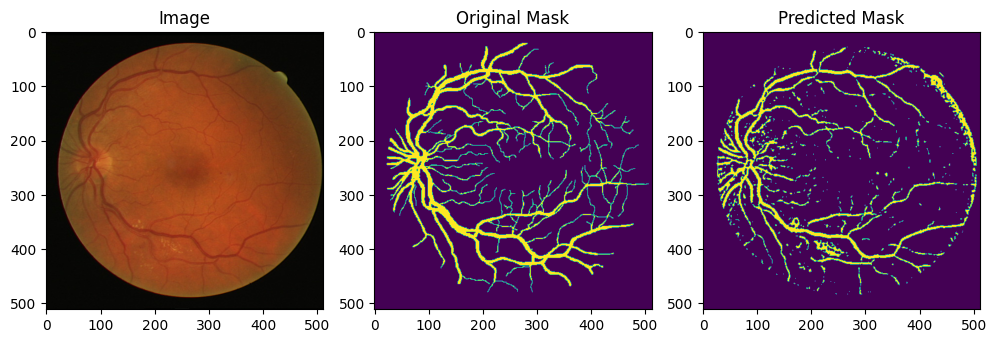

In [ ]:
make_predictions(unet, np.array(test_images[2]), np.array(test_masks_processed[2]), thres=0.15)

Congratulations, You have finished this guide to implementing and training a U-Net!